In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special as sp
import os as os
import multiprocessing
from joblib import Parallel, delayed
from time import time as ti
from skimage.restoration import denoise_wavelet
import pickle
#import CoreFunctions as cf
import sys
import random
import psutil
import gc

In [2]:
DataFolder = '/sciclone/scr10/dchendrickson01/Recordings2/'
DataFolder = '/scratch/Recordings2/'

DateString = 'Good'
LastGoodModel = 20

TIME_STEPS = 1200
Skips = 600
RollSize = 50

LastSuccesfull = 40

tic = ti()
start = tic

MemoryProtection = False

In [3]:
import CoreFunctions as cf

In [4]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import numpy as np

2024-12-29 16:39:37.355816: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-29 16:39:37.377384: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-29 16:39:37.383956: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-29 16:39:37.399765: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
class ConvAutoencoder:
    @staticmethod
    def build(width, height, depth, filters=(32, 64), latentDim=24):
        inputShape = (height, width, depth)
        chanDim = -1
        inputs = Input(shape=inputShape)
        x = inputs

        for f in filters:
            x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        volumeSize = K.int_shape(x)
        print("Volume Size:", volumeSize)
        x = Flatten()(x)
        latent = Dense(latentDim)(x)

        encoder = Model(inputs, latent, name="encoder")

        latentInputs = Input(shape=(latentDim,))
        flattenedVolumeSize = int(np.prod(volumeSize[1:]))
        print("Flattened Volume Size:", flattenedVolumeSize)
        x = Dense(flattenedVolumeSize)(latentInputs)
        x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

        for f in filters[::-1]:
            x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
            x = LeakyReLU(alpha=0.2)(x)
            x = BatchNormalization(axis=chanDim)(x)

        x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
        outputs = Activation("sigmoid")(x)

        decoder = Model(latentInputs, outputs, name="decoder")
        autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

        return (encoder, decoder, autoencoder)


In [6]:
# set the matplotlib backend so figures can be saved in the background
#import matplotlib
#matplotlib.use("Agg")
# import the necessary packages
#from pyimagesearch.convautoencoder import ConvAutoencoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
# construct the argument parse and parse the arguments

In [7]:
import random
import tensorflow as tf
from tensorflow.keras.models import load_model

In [8]:
from tensorflow.keras.callbacks import Callback

In [9]:
import keras
import re

In [10]:
directory = '/scratch/models/'
target_file = f'3DFP_{DateString}_{str(LastGoodModel).zfill(3)}_good2_ae.keras'

ImageShape=[5,32,600,3]

encoder = load_model(directory+target_file[:-8]+'en.keras')
decoder = load_model(directory+target_file[:-8]+'de.keras')

autoencoder_input = Input(shape=(ImageShape[1], ImageShape[2], ImageShape[3]))

# Pass the input through the encoder and decoder
encoded_repr = encoder(autoencoder_input)
reconstructed = decoder(encoded_repr)

# Create the reassembled autoencoder model
autoencoder = Model(autoencoder_input, reconstructed)

2024-12-29 16:39:40.385280: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14784 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0000:82:00.0, compute capability: 7.0


In [11]:
import matplotlib.gridspec as gridspec

In [12]:
def QuadPlot(Data, FP, Err, Pred, file='', tic=''):
    # Create a figure
    fig = plt.figure(dpi=300)
    
    # Create a GridSpec with 2 rows and 2 columns, and different width ratios for columns
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])  # Adjust width_ratios as needed
    
    # First row, first column (smaller)
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(Data[0,:],linewidth=0.5,color='r')
    ax1.plot(Data[1,:],linewidth=0.5, color='lime')
    ax1.plot(Data[2,:],linewidth=0.5,color='b')
    plt.xlim([0,1200])
    if file != '' and tic != '':
        print(f'Recorded Signal, {file} at {tic}')
    ax1.set_title(f'Recorded Signal')
    
    # First row, second column (larger)
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(np.abs(FP), origin='lower',aspect='auto')
    ax2.axis("off")
    ax2.set_title('3D Fingerprint')

    TEC0 = np.sum(Err[:,:,0],axis=0)
    TEC1 = np.sum(Err[:,:,1],axis=0)
    TEC2 = np.sum(Err[:,:,2],axis=0)
    
    ax3 = fig.add_subplot(gs[1, 0])
    Xrange = list(range(0,1200,2))
    ax3.plot(Xrange,np.sum(np.sum(Err,axis=2),axis=0),linewidth=0.8,color='black')
    ax3.plot(Xrange,TEC0,linewidth=0.5,color='r')
    ax3.plot(Xrange,TEC1,linewidth=0.5,color='lime')
    ax3.plot(Xrange,TEC2,linewidth=0.5,color='b')
    plt.xlim([0,1200])
    SumErr = np.sum(np.sum(np.sum(Err,axis=2),axis=0))
    ax3.set_title('Sum Errors')
    print(rf'Sum Error over Time, $\Sigma$ = {np.sum(Err):.2f}')

    # Second row, second column (larger)
    combined_data = np.concatenate((TEC0,TEC1,TEC2))
    bins = np.histogram_bin_edges(combined_data, bins=30)
    
    hist1, bins = np.histogram(TEC0, bins=bins)
    hist2, _ = np.histogram(TEC1, bins=bins)
    hist3, _ = np.histogram(TEC2, bins=bins)
    
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.hist([TEC0, TEC1, TEC2],bins=bins,color=['r','lime','b'],stacked=True)
    #ax4.bar(bins[:-1], hist1, width=np.diff(bins), color='r')
    #ax4.bar(bins[:-1], hist2, width=np.diff(bins), bottom=hist1, color='lime')
    #ax4.bar(bins[:-1], hist3, width=np.diff(bins), bottom=hist2, color='b')
    ax4.set_title('Error Histogram')
    plt.tight_layout()

       
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()


In [13]:
from matplotlib.colors import LinearSegmentedColormap

# Define the custom colormap
colors = [(0, 0, 0), (0, 1, 0)]  # Black to Lime
n_bins = 100  # Number of bins in the colormap
cmap_name = 'black_lime'
lime_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

colors = [(0, 0, 0), (1, 0, 0)]  # Black to Lime
n_bins = 100  # Number of bins in the colormap
cmap_name = 'black_red'
red_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

colors = [(0, 0, 0), (0, 0, 1)]  # Black to Lime
n_bins = 100  # Number of bins in the colormap
cmap_name = 'black_blue'
blue_cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)


In [14]:
def TDFPBuildChart(Data, FP, Err, Pred, file='', tic=''):

    gs = gridspec.GridSpec(5, 1)  # Adjust width_ratios as needed

    fig = plt.figure(figsize=(8,11),dpi=300)
    
    axs0 = fig.add_subplot(gs[0, 0])
    axs0.plot(Data[0,:],linewidth=0.5,color='r')
    axs0.plot(Data[1,:],linewidth=0.5, color='lime')
    axs0.plot(Data[2,:],linewidth=0.5,color='b')
    plt.xlim([0,1200])
    ticks = np.linspace(0, 1200, 7) 
    labels = np.linspace(0, 600, 7) 
    plt.xticks(ticks, labels)

    FpShape = np.shape(FP[:,:,0])
    Al,Ms  = np.meshgrid(np.arange(0,FpShape[1]),np.arange(0,FpShape[0]))
    
    axs1 = fig.add_subplot(gs[1, 0])
    axs1.contourf(Al,Ms, FP[:,:,0],cmap=red_cmap,levels=12)
    axs1.axis("off")

    axs2 = fig.add_subplot(gs[2, 0])
    axs2.contourf(Al,Ms, FP[:,:,1],cmap=lime_cmap,levels=12)
    axs2.axis("off")
    
    axs3 = fig.add_subplot(gs[3, 0])
    axs3.contourf(Al,Ms, FP[:,:,2],cmap=blue_cmap,levels=12)
    axs3.axis("off")

    axs4 = fig.add_subplot(gs[4, 0])
    axs4.imshow(np.abs(FP), origin='lower',aspect='auto')
    axs4.axis("off")
    axs4.set_title('3D Fingerprint')

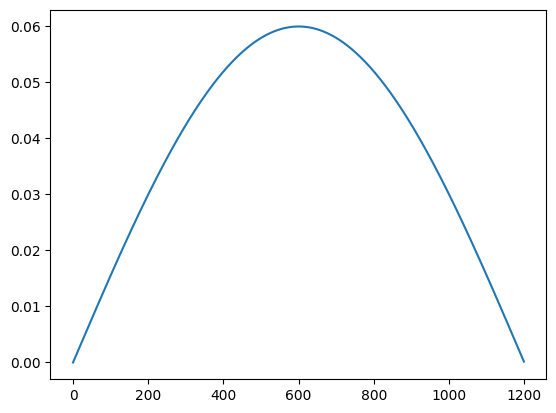

In [29]:
fig = plt.figure()
plt.plot([0.06*np.sin(i /1200 * np.pi)  for i in range(1200)])
plt.show()

In [31]:
SimGood = [[0.05*np.sin(i /1200 * np.pi)  for i in range(1200)],
           [0.06*np.sin(i / 5.5) + 0.06*np.sin(i / 11.0) for i in range(1200)],
           [-0.02*np.sin(i /1200 * np.pi)  for i in range(1200)]]
#           [0.06*np.sin(i / 6.6) + 0.06*np.sin(i / 13.2) for i in range(1200)],
#           [0.06*np.sin(i / 7.7) + 0.06*np.sin(i / 15.4) for i in range(1200)]]

In [16]:
SimBad = [[np.random.normal(loc=0, scale=0.1, size=1) for i in range(1200)],
          [np.random.normal(loc=0.05, scale=0.11, size=1) for i in range(1200)],
          [np.random.normal(loc=-0.02, scale=0.09, size=1) for i in range(1200)]]
          

In [32]:
GoodPrint = (cf.makeMPFast(SimGood, wvt = 'sym4', scales = 32, spacer = 2, title = '')) / 255.0
BadPrint = (cf.makeMPFast(SimBad, wvt = 'sym4', scales = 32, spacer = 2, title = '')) / 255.0

In [33]:
Sims = []
Sims.append(GoodPrint[:, ::2, :])
Sims.append(BadPrint[:, ::2, :])
SimInputs = tf.convert_to_tensor(Sims)

In [34]:
SimPredicts = autoencoder.predict(SimInputs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [35]:
GoodDiff = GoodPrint[:, ::2, :] - SimPredicts[0]
BadDiff = BadPrint[:, ::2, :] - SimPredicts[1]


In [36]:
np.shape(np.matrix(SimGood))

(3, 1200)

In [37]:
np.asarray(SimGood)[0,:]

array([0.       , 0.0001309, 0.0002618, ..., 0.0003927, 0.0002618,
       0.0001309])

Recorded Signal, Good Simulation at 0
Sum Error over Time, $\Sigma$ = -498.75


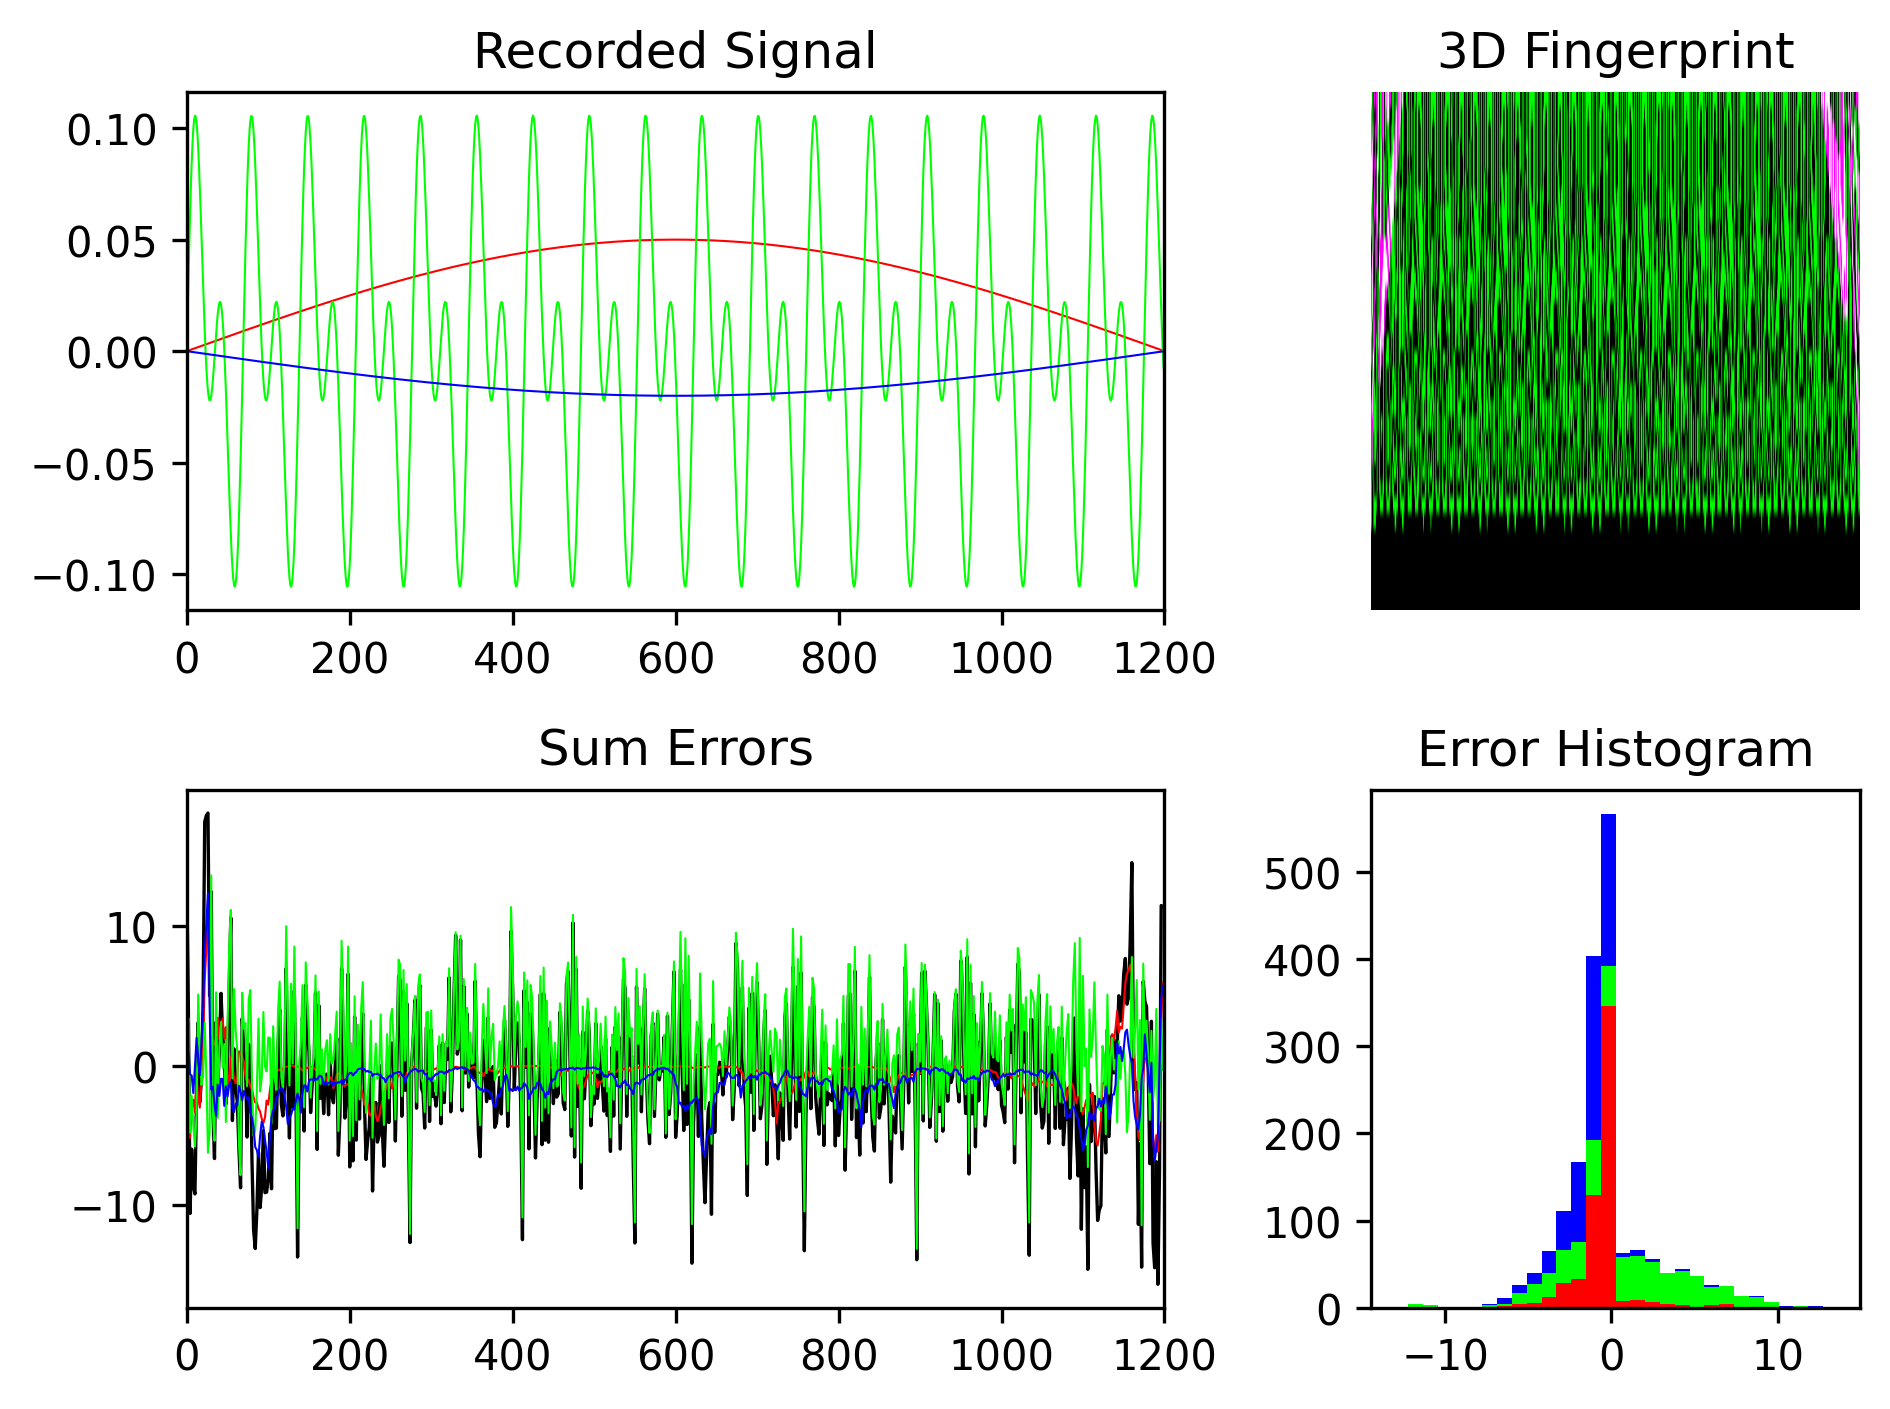

In [38]:
QuadPlot(np.asarray(SimGood), GoodPrint[:, ::2, :], GoodDiff, SimPredicts[0], 'Good Simulation', '0')

Recorded Signal, Bad Simulation at 0
Sum Error over Time, $\Sigma$ = 4017.55


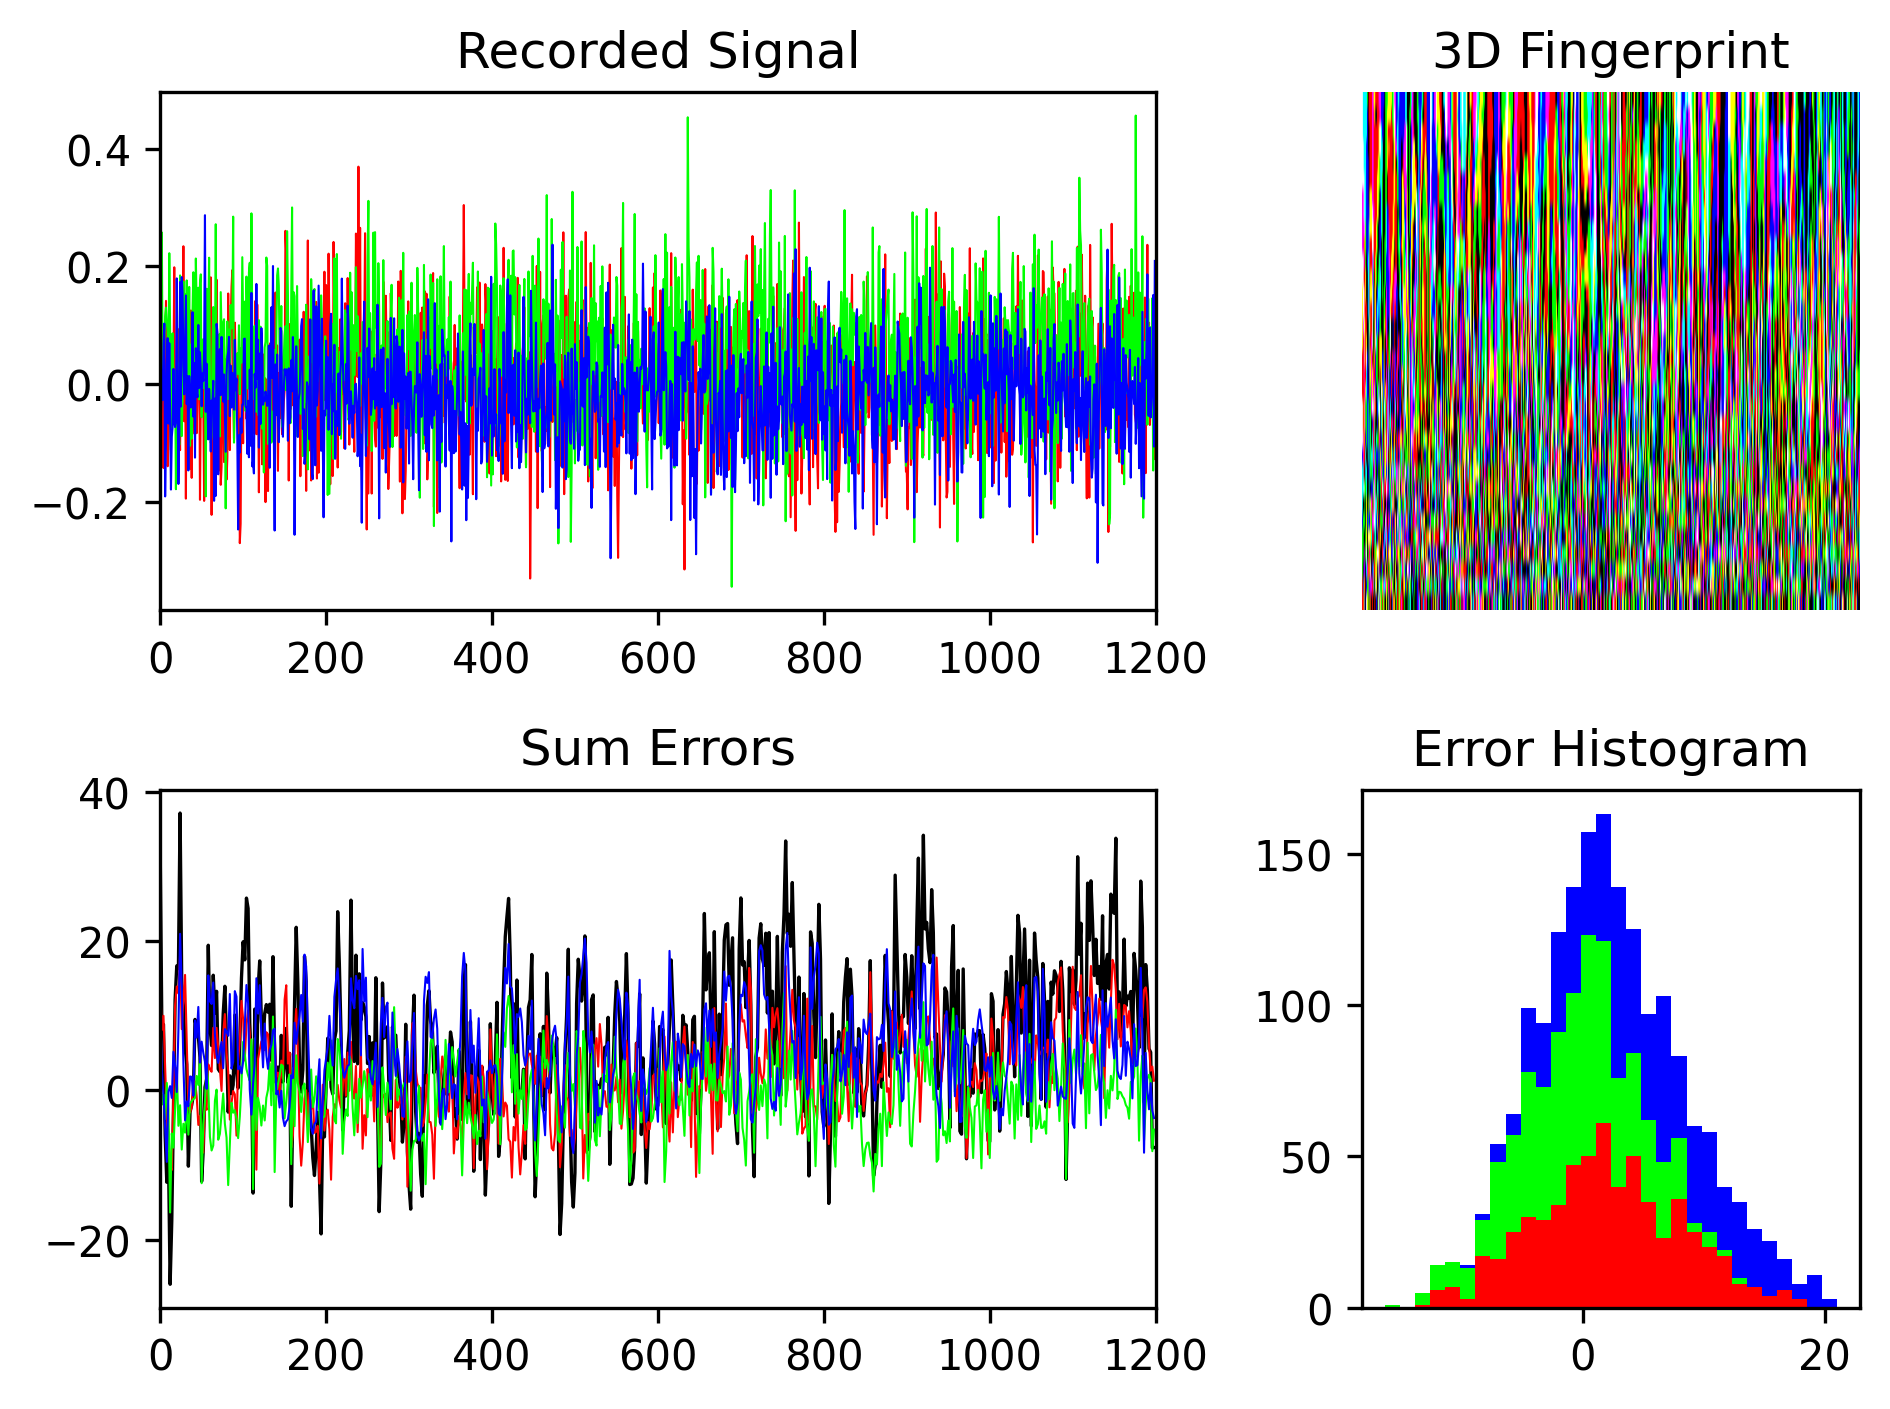

In [39]:
QuadPlot(np.asarray(SimBad), BadPrint[:, ::2, :], BadDiff, SimPredicts[1], 'Bad Simulation', '0')